In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

In [2]:
gym.__version__

'1.0.0'

In [3]:
env = gym.make("CarRacing-v3", render_mode="rgb_array")  # среда
state_dim = env.observation_space.shape
print(state_dim)
action_dim = env.action_space.shape[0]
print(action_dim)

(96, 96, 3)
3


In [4]:
# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# class QNet(nn.Module):
#     def __init__(self, state_dim, hidden_dim=64):
#         super().__init__()

#         self.flatten = nn.Flatten()
#         self.hidden = nn.Linear(state_dim[0]*state_dim[1]*state_dim[2]*2, hidden_dim)
#         self.output = nn.Linear(hidden_dim, 1)

#     def forward(self, s, a):
#         outs = torch.concat((s, a), dim=-1)
#         outs = self.flatten(outs)
#         outs = self.hidden(outs)
#         outs = F.relu(outs)
#         outs = self.output(outs)
#         return outs

class QNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(input_dim[2]*2, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(128, 1)

    def forward(self, s, a):
        x = torch.concat((s, a), dim=-1)
        x = x.permute(0, 3, 1, 2)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.avg_pool(x)
        # x = self.flatten(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

q_origin_model = QNet(state_dim).to(device)  # Q_phi
q_target_model = QNet(state_dim).to(device)  # Q_phi'
_ = q_target_model.requires_grad_(False)  # target model doen't need grad

In [6]:
# class PolicyNet(nn.Module):
#     def __init__(self, state_dim, action_dim, hidden_dim=64):
#         super().__init__()

#         self.flatten = nn.Flatten()
#         self.hidden = nn.Linear(state_dim[0]*state_dim[1]*state_dim[2], hidden_dim)
#         self.output = nn.Linear(hidden_dim, action_dim)

#     def forward(self, s):
#         outs = self.flatten(s)
#         outs = self.hidden(outs)
#         outs = F.relu(outs)
#         outs = self.output(outs)
#         outs = torch.tanh(outs)
#         return outs

class PolicyNet(nn.Module):

    def __init__(self, input_dim, action_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(input_dim[2], 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(128, action_dim)
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2) # permute(1, 0, 2, 3)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.avg_pool(x)
        # x = self.flatten(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(self.linear(x))
        return x

mu_origin_model = PolicyNet(state_dim, action_dim).to(device)  # mu_theta
mu_target_model = PolicyNet(state_dim, action_dim).to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

In [7]:
gamma = 0.99
opt_q = torch.optim.AdamW(q_origin_model.parameters(), lr=0.005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.005)

def optimize(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(np.array(states), dtype=torch.float).to(device)
    actions = torch.tensor(np.array(actions), dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1).unsqueeze(dim=2)
    actions = actions.repeat(1, 96, 96, 1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float).to(device)
    dones = torch.tensor(np.array(dones), dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Optimize critic loss
    opt_q.zero_grad()
    states = states.clone().detach().requires_grad_(True)
    actions = actions.clone().detach().requires_grad_(True)
    q_org = q_origin_model(states, actions)
    mu_tgt_next = mu_target_model(next_states)
    mu_tgt_next = mu_tgt_next.unsqueeze(dim=1).unsqueeze(dim=2)
    mu_tgt_next = mu_tgt_next.repeat(1, 96, 96, 1)
    next_states = next_states.clone().detach().requires_grad_(True)
    mu_tgt_next = mu_tgt_next.clone().detach().requires_grad_(True)
    q_tgt_next = q_target_model(next_states, mu_tgt_next)
    q_tgt = rewards + gamma * (1.0 - dones) * q_tgt_next
    loss_q = F.mse_loss(
        q_org,
        q_tgt,
        reduction="none")
    loss_q.sum().backward()
    opt_q.step()

    # Optimize actor loss
    opt_mu.zero_grad()
    mu_org = mu_origin_model(states)
    mu_org = mu_org.unsqueeze(dim=1).unsqueeze(dim=2)
    mu_org = mu_org.repeat(1, 96, 96, 1)
    for p in q_origin_model.parameters():
        p.requires_grad = False # disable grad in q_origin_model before computation
    q_tgt_max = q_origin_model(states, mu_org)
    (-q_tgt_max).sum().backward()
    opt_mu.step()
    for p in q_origin_model.parameters():
        p.requires_grad = True # enable grad again

In [8]:
tau = 0.005

def update_target():
    for var, var_target in zip(q_origin_model.parameters(), q_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

In [9]:
class ReplayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []
        self._next_idx = 0

    def add(self, item):
        if len(self.buffer) > self._next_idx:
            self.buffer[self._next_idx] = item
        else:
            self.buffer.append(item)
        if self._next_idx == self.buffer_size - 1:
            self._next_idx = 0
        else:
            self._next_idx = self._next_idx + 1

    def sample(self, batch_size):
        indices = [random.randint(0, len(self.buffer) - 1) for _ in range(batch_size)]
        states   = [self.buffer[i][0] for i in indices]
        actions  = [self.buffer[i][1] for i in indices]
        rewards  = [self.buffer[i][2] for i in indices]
        n_states = [self.buffer[i][3] for i in indices]
        dones    = [self.buffer[i][4] for i in indices]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = ReplayBuffer(buffer_size=20_000)

In [10]:
"""
Ornstein-Uhlenbeck noise implemented by OpenAI
Copied from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py
"""
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(3), sigma=np.ones(3) * 0.5, theta=0.5)

In [11]:
# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s, episode_n, n):
    with torch.no_grad():
        s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        action_det = mu_origin_model(s_batch)
        action_det = action_det.squeeze(dim=1)
        # noise_decrease=1/(episode_n - n)
        # noise = ou_action_noise()
        noise = np.maximum(np.array([0, 0, 0]), ou_action_noise()*(1 - 1 / (episode_n - n)))
        # print('noise', noise)
        action = action_det.cpu().numpy() + noise
        # print('action', action)
        action = np.clip(action, -1.0, 1.0)
        # print('action clip', action)
        action = F.softmax(torch.tensor(action), dim=-1)
        # print('action softmax', action)
        # action = torch.multinomial(action, num_samples=1)
        action_max = np.zeros(action.shape)
        # print('action_max', action_max)
        max_idx = action[0].argmax()
        # print('max_idx', max_idx)
        # Присваивание максимальному значению
        action_max[0][max_idx] = action[0][max_idx]
        # print('action_max', action_max)
        return action_max # .numpy() # float(action.item())

In [26]:
arr = np.array([0.2, 0.3, 0.5])
# Нахождение индекса максимального значения
max_idx = arr.argmax()
# Создание нового тензора с нулями
result = np.zeros(len(arr))
# Присваивание максимальному значению
result[max_idx] = arr[max_idx]
result

array([0. , 0. , 0.5])

In [12]:
reward_records = []

In [16]:
batch_size = 128
episode_n = 1500
trajectory_len = 10000

for i in range(episode_n):
    # Run episode till done
    s, _ = env.reset()
    done = False
    cum_reward = 0
    # num = 1
    for tr in range(trajectory_len):
    # while not done:
        a = pick_sample(s, episode_n, i).squeeze()
        s_next, r, done, _, _ = env.step(a)
        buffer.add([s, a, r, s_next, float(done)])
        cum_reward += r
        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next
        # print(cum_reward)
        # print(num, end='\r')
        # num += 1
        if done:
            break

    # Output total rewards in episode (max 500)
    print(f"Run episode {i} with rewards {cum_reward} trajectory_len {tr+1}")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    # if np.average(reward_records[-50:]) > 475.0:
    #     break

print("\nDone")

Run episode 0 with rewards -993.630573248565 trajectory_len 10000
Run episode 1 with rewards -992.5925925927497 trajectory_len 10000
Run episode 2 with rewards -993.1972789117219 trajectory_len 10000
Run episode 3 with rewards -992.1259842521256 trajectory_len 10000
Run episode 4 with rewards -992.9824561405081 trajectory_len 10000
Run episode 5 with rewards -962.8482972137796 trajectory_len 10000
Run episode 6 with rewards -314.2188405796951 trajectory_len 3520
Run episode 7 with rewards -48.54831460674147 trajectory_len 273
Run episode 8 with rewards -61.97021276595776 trajectory_len 259
Run episode 9 with rewards 49.15016835016894 trajectory_len 193
Run episode 10 with rewards -55.282191780822224 trajectory_len 273
Run episode 11 with rewards -456.1942652329913 trajectory_len 4459
Run episode 12 with rewards -951.7241379311833 trajectory_len 10000
Run episode 13 with rewards -978.1021897811755 trajectory_len 10000
Run episode 14 with rewards -975.4385964913813 trajectory_len 10000
R

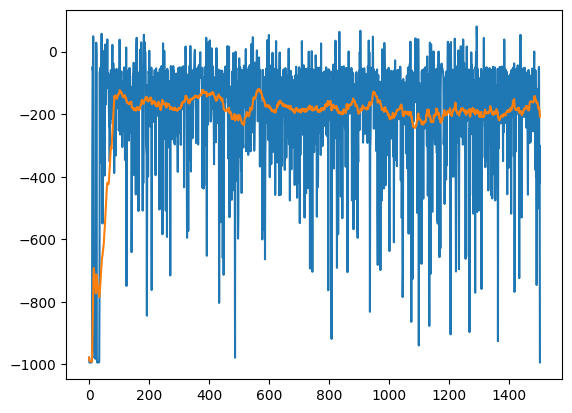

In [17]:
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

In [18]:
# env2 = gym.make("CarRacing-v3", render_mode="rgb_array")
n = 11
for i in range(2):
    env2 = RecordVideo(env, video_folder="./car-racing-videos", video_length=5000, name_prefix=f'car-racing{n+i}', fps=30, disable_logger=True)
    termination, truncation = False, False
    _, _ = env2.reset(seed=123)
    _ = env2.action_space.seed(123)
    while not (termination or truncation):
        obs, rew, termination, truncation, info = env2.step(env2.action_space.sample())

    env2.close()
len(os.listdir("./car-racing-videos"))

12